In [1]:
import os

import anndata
import cooler
import numpy as np
import pandas as pd
import scanpy as sc
import scglue
import tqdm

import matplotlib.pyplot as plt

In [2]:
hic = anndata.read_h5ad("/home/micl/workspace/lmh_data/Lee2019/scHiC.h5ad")
hic.obs_names = hic.obs_names.str.split(r"[:_]").map(lambda x: '_'.join(x[:-2]))
hic.obs["cell_type"] = hic.obs_names.str.split(r"[:_]").map(lambda x: x[5])
hic.obs["batch"] = hic.obs_names.str.split(r"[:_]").map(lambda x: '{}_{}'.format(x[0], x[1]))

/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid va

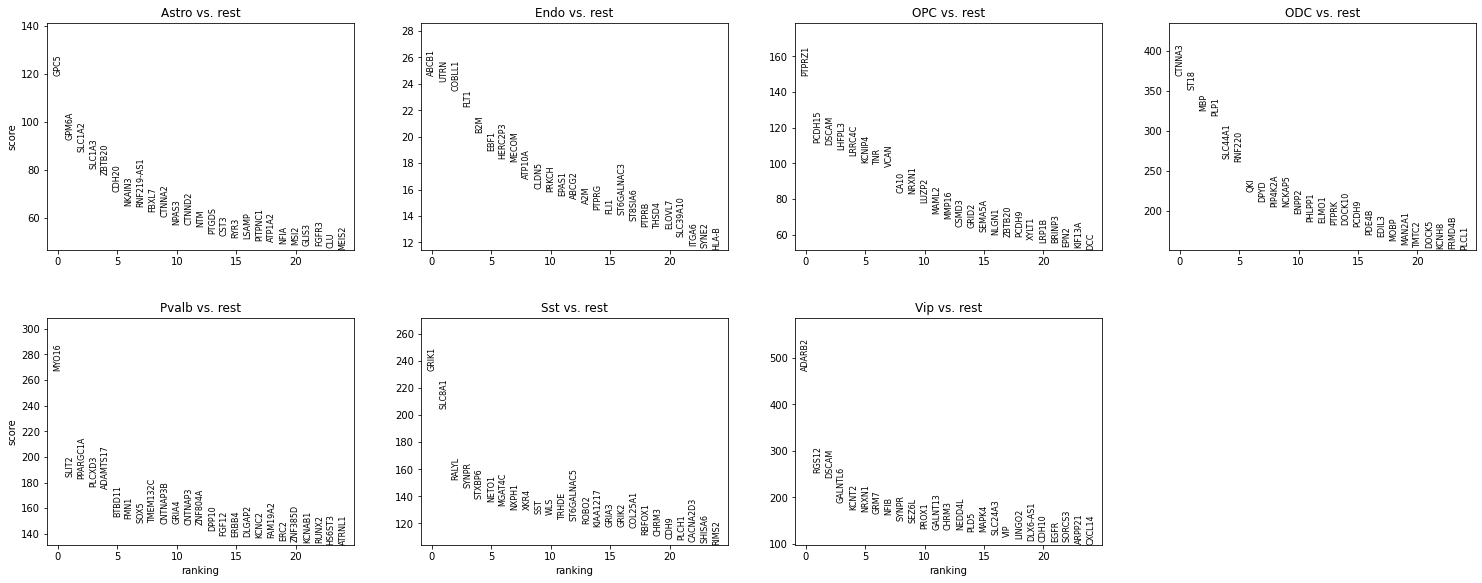

In [3]:
rna = anndata.read_h5ad("/home/micl/workspace/lmh_data/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/home/micl/workspace/lmh_data/public/gencode.v19.annotation.gtf",
    gtf_by="gene_name"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(rna, n_genes=25, sharey=False)

In [4]:
marker_genes = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:3000]
marker_genes_index = marker_genes.values.reshape(-1)
rna.var['marker_genes'] = False
rna.var.loc[marker_genes_index, 'marker_genes'] = True
rna.var

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,havana_gene,tag,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std,marker_genes
DDX11L1,chr1,11868.0,14412.0,DDX11L1,.,+,.,.,.,.,...,OTTHUMG00000000961.2,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
WASH7P,chr1,14362.0,29806.0,WASH7P,.,-,.,.,.,.,...,OTTHUMG00000000958.1,NaN,False,NaN,0.013284,0.013376,0.904079,0.00857,0.084148,True
MIR1302-2,chr9,27656.0,30891.0,MIR1302-2,.,+,.,.,.,.,...,OTTHUMG00000019418.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
FAM138A,chr1,34553.0,36081.0,FAM138A,.,-,.,.,.,.,...,OTTHUMG00000000960.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
OR4G4P,chr1,52472.0,54936.0,OR4G4P,.,+,.,.,.,.,...,OTTHUMG00000185779.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TPTE2P4,chrY,28654359.0,28725837.0,TPTE2P4,.,+,.,.,.,.,...,OTTHUMG00000036765.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
SLC25A15P1,chrY,28732788.0,28737748.0,SLC25A15P1,.,-,.,.,.,.,...,OTTHUMG00000036811.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
PARP4P1,chrY,28740997.0,28780799.0,PARP4P1,.,-,.,.,.,.,...,OTTHUMG00000036812.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
FAM58CP,chrY,28772666.0,28773306.0,FAM58CP,.,-,.,.,.,.,...,OTTHUMG00000036813.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False


In [5]:
def _norm(hic):
    tmp = hic.copy()
#     for i in tqdm.notebook.tqdm(range(tmp.X.shape[1]), desc='column'):
#         left, right = max(i-100, 0), i+101
#         tmp.X[:, i] = hic.X[:, i] / hic.X[:, left:right].sum(axis=1)
    _max = tmp.X.max(axis=1)
    tmp.X = np.round((1/_max).reshape((1/_max).shape[0],1) * tmp.X * 1000, 0)
    return tmp

# tmp = hic.copy()
# # tmp.X[tmp.X!=0] = np.log(tmp.X[tmp.X!=0])
# _mean = tmp.X.mean(axis=1)
# tmp.X = (1/_mean).reshape((1/_mean).shape[0],1) * tmp.X

tmp = _norm(hic)

cell_types = ['Astro', 'Endo', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip']
def t(celltype):
#     tmp = tmp[tmp.obs[tmp.obs['batch']=='190315_29yr'].index]
#     tmp.X = tmp.X / tmp.X.max()
    
#     tmp.X[tmp.X>10] = np.log(tmp.X[tmp.X>10]-9) + 9

    result = pd.DataFrame(columns=cell_types)
    for index, row in rna.var.loc[marker_genes[celltype]].iterrows():
        _result = dict()
        for t in cell_types:
#             obs_index = tmp.obs[(tmp.obs['batch']=='190315_29yr')&(tmp.obs['cell_type']==t)].index
            obs_index = tmp.obs[tmp.obs['cell_type']==t].index
            if row['strand'] == '+':
                _start = int((row['chromStart']-5000)/10000)*10000
                _end = int(row['chromEnd']/10000)*10000
            else:
                _start = int((row['chromEnd']+5000)/10000)*10000
                _end = int(row['chromStart']/10000)*10000
            var_index = [
                '{}_{}'.format(row['chrom'], i) for i in range(min(_start, _end), max(_start, _end)+10000, 10000)]
            _result[t] = [tmp[obs_index, var_index].X.mean()]
        result = pd.concat([result, pd.DataFrame(columns=cell_types, data=_result, index=[index])])
    return result

def _rank(result, cell_type):
    _result = result.copy()
    for index, row in _result.iterrows():
        _result.loc[index] = _result.loc[index].rank(ascending=False)
    return set(_result[_result[cell_type]==1].index) & set(rna.var[rna.var['highly_variable']==True].index)

In [6]:
_Astro = _rank(t('Astro'), 'Astro')
_Endo = _rank(t('Endo'), 'Endo')
_ODC = _rank(t('ODC'), 'ODC')
_OPC = _rank(t('OPC'), 'OPC')
_Pvalb = _rank(t('Pvalb'), 'Pvalb')
_Sst = _rank(t('Sst'), 'Sst')
_Vip = _rank(t('Vip'), 'Vip')

In [7]:
for i in [_Astro, _Endo, _ODC, _OPC, _Pvalb, _Sst, _Vip]:
    print(len(i))

152
35
291
282
20
81
39


In [ ]:
np.save('marker_gene.npy', np.array(_Astro.union(_Endo, _ODC, _OPC, _Pvalb, _Sst, _Vip)))

In [ ]:
rna.var.loc[list(_Astro)]

In [ ]:
_test = tmp[tmp.obs[tmp.obs['cell_type']=='Astro'].index, 'chr1_154840000']
low_cells = _test[_test.X==0].obs.index

_test = np.array(tmp[low_cells, 'chr1_154840000'].X)
plt.hist(_test, bins=400, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[low_cells, 'chr1_154850000'].X)
plt.hist(_test, bins=400, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[low_cells, 'chr1_154830000'].X)
plt.hist(_test, bins=400, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
for index, row in rna.var.loc[list(_Astro)].iterrows():
    if row['strand'] == '+':
        _start = int((row['chromStart']-5000)/10000)*10000
        _end = int(row['chromEnd']/10000)*10000
    else:
        _start = int((row['chromEnd']+5000)/10000)*10000
        _end = int(row['chromStart']/10000)*10000
    _test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='Astro'].index, '{}_{}'.format(row['chrom'], _start)].X)
    plt.hist(_test, bins=400, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
for index, row in rna.var.loc[list(_Astro)].iterrows():
    if row['strand'] == '+':
        _start = int((row['chromStart']-5000)/10000)*10000
        _end = int(row['chromEnd']/10000)*10000
    else:
        _start = int((row['chromEnd']+5000)/10000)*10000
        _end = int(row['chromStart']/10000)*10000
    _test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='Endo'].index, '{}_{}'.format(row['chrom'], _start)].X)
    plt.hist(_test, bins=400, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
for index, row in rna.var.loc[list(_Astro)].iterrows():
    if row['strand'] == '+':
        _start = int((row['chromStart']-5000)/10000)*10000
        _end = int(row['chromEnd']/10000)*10000
    else:
        _start = int((row['chromEnd']+5000)/10000)*10000
        _end = int(row['chromStart']/10000)*10000
    _test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='ODC'].index, '{}_{}'.format(row['chrom'], _start)].X)
    plt.hist(_test, bins=400, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
tmp = hic.copy()

_mean = tmp.X.mean(axis=1)
tmp.X = np.round((1/_mean).reshape((1/_mean).shape[0],1) * tmp.X * 100, 0)
# _max = tmp.X.max(axis=1)
# tmp.X = np.round((1/_max).reshape((1/_max).shape[0],1) * tmp.X * 1000, 0)

# _max = tmp.X.max(axis=1).mean()
# tmp.X = tmp.X / _max

In [ ]:
import tqdm

tmp = hic.copy()
# _test = tmp[tmp.obs[tmp.obs['cell_type']=='Astro'].index, :].X
# _test = _test.mean(axis=0)
for i in tqdm.notebook.tqdm(range(tmp.X.shape[1]), desc='column'):
    left, right = max(i-100, 0), i+101
    tmp.X[:, i] = hic.X[:, i] / hic.X[:, left:right].sum(axis=1)

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='Astro'].index, 'chr1_154840000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='Endo'].index, 'chr1_2460000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='ODC'].index, 'chr1_2460000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = tmp.X.mean(axis=1)
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
plt.hist(hic.X.max(axis=1), bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
rna.var.loc[['GPC5', 'ABCB1']]

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='Astro'].index, 'chr13_92050000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='Endo'].index, 'chr13_92050000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='ODC'].index, 'chr13_92050000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = np.array(tmp[tmp.obs[tmp.obs['cell_type']=='OPC'].index, 'chr13_92050000'].X)
print(_test.mean())
plt.hist(_test, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)

In [ ]:
_test = tmp[tmp.obs[tmp.obs['cell_type']=='Astro'].index, 'chr11_330000']
_test[_test.X>5].obs

In [ ]:
_test = tmp[tmp.obs[tmp.obs['cell_type']=='Endo'].index, 'chr11_330000']
_test[_test.X>5].obs

In [ ]:
hic['190315_29yr_6_A3_AD012_Endo'].X.max()

In [ ]:
hic[hic.obs[hic.obs['cell_type']=='Endo'].index].X.max()

In [ ]:
tmp[tmp.obs[tmp.obs['cell_type']=='Endo'].index].X.mean()

In [ ]:
_test = tmp[tmp.obs[tmp.obs['cell_type']=='ODC'].index, 'chr11_330000']
_test[_test.X>5].obs

In [ ]:
_test = tmp[tmp.obs[tmp.obs['cell_type']=='OPC'].index, 'chr11_330000']
_test[_test.X>5].obs

In [ ]:
_max = hic.X.max(axis=1)
np.round((1/_max).reshape((1/_max).shape[0],1) * hic.X * 1000, 0)

In [ ]:
_test = hic.copy()
_test.X[_test.X>10] = np.log(_test.X[_test.X>10]-9) + 9
_test

In [ ]:
_test.shape

In [ ]:
hic.X.shape

In [ ]:
hic.X.argsort()

In [ ]:
from matplotlib import pyplot as plt 
plt.hist(_test.X[_test.X>=1], bins=400, facecolor="blue", edgecolor="black", alpha=0.7)